In [1]:
import os
import git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date
import matplotlib.dates as mdates
import plotly.graph_objects as go
from datetime import date, datetime, timedelta

In [2]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    return git_repo.working_dir

In [4]:
#Import and format Temperature data

temp_col = ['DATE','TIME','T1','T2','T3','T4'] #column names
temp_use = list(np.arange(len(temp_col)))

# Read temperature csv file with name: 'month_startdate-enddate'
df_temp = pd.read_csv(os.path.join(get_git_root(os.getcwd()), 'data', 'raw_data', 'temperature', 'all_data', '05_29-31.csv'),header=None,skiprows=1,names=temp_col,na_filter=True,
                   na_values=-200,usecols=temp_use)

df_temp['DATE'] = pd.to_datetime(df_temp['DATE']+' '+df_temp['TIME']) # convert DATE and TIME to datetime formate in DATE column

# get rid of biodgigester thermocouple errors
df_temp['T3'] = pd.to_numeric(df_temp['T3'], errors='coerce')

#set datetime as index
df_temp.set_index('DATE', inplace=True)

# On may 30th (temperature filename '05_29-31.csv', the main tank thermocouple experiences a malfunction which makes it underestimate temperature by 6°C for 3 hours. Manually adjust
dip_start_date = '2024-05-30 12:32'
dip_end_date = '2024-05-30 15:33'
dip_start_date_dt = datetime.strptime(dip_start_date, '%Y-%m-%d %H:%M')
dip_end_date_dt = datetime.strptime(dip_end_date, '%Y-%m-%d %H:%M')
# 2. Add 6 degrees to this portion of the data
df_temp.loc[dip_start_date_dt:dip_end_date_dt, 'T2'] += 6


In [12]:
#Import and format Light data

lux_col = ['PLACE','DATE','TIME','VALUE','UNIT'] #column names
lux_use = list(np.arange(len(lux_col)))

# Read latest light csv file, as it will contain all previous data
df_lux = pd.read_csv(os.path.join(os.getcwd(), 'Light_Data', 'LUX_07_01.csv'),header=None,skiprows=1,names=lux_col,na_filter=True,
                   na_values=-200,usecols=lux_use) #fetch the latest lux csv file
df_lux = df_lux[df_lux['DATE'] != 'Date'] #get rid of the logging restarts
df_lux = df_lux[df_lux['UNIT'] != 'Ft cd   '] # get rid of false inputs

df_lux['VALUE'] = (df_lux['VALUE'].astype(int))*0.0079 #change string values to integer and convert lux to W/m2 by using conversion factor for sunlight: 0.0079W/m2/lux

df_lux['DATE'] = pd.to_datetime(df_lux['DATE']+' '+df_lux['TIME'])# convert DATE and TIME to datetime formate in DATE column

start_time = df_temp.index.min() #find the earliest timestamp for the temp recording
end_time = df_temp.index.max() #find the latest timestamp for the temp recording

df_lux_restricted = df_lux[(df_lux['DATE'] >= start_time) & (df_lux['DATE'] <= end_time)] #restrict the lux readings to that timeperiod


/var/folders/yg/cg9wv8tx2mv56kw5vh03hsnm0000gn/T/ipykernel_5581/841189893.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_lux['DATE'] = pd.to_datetime(df_lux['DATE']+' '+df_lux['TIME'])# convert DATE and TIME to datetime formate in DATE column


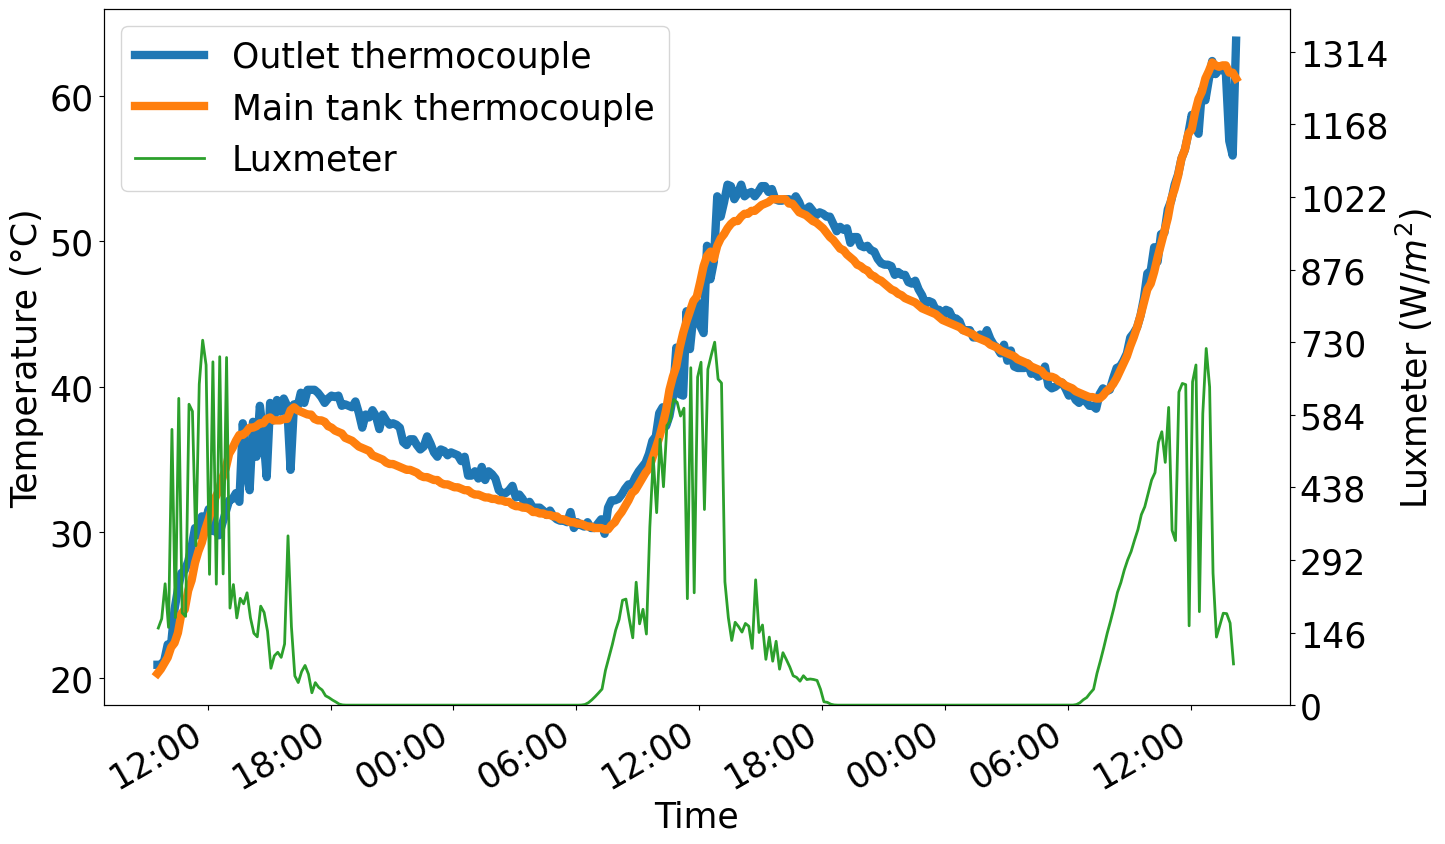

In [14]:
# PLOT TEMPERATURE AND LIGHT
plt.rcParams.update({'font.size': 25})
fig, ax1 = plt.subplots(figsize=(15, 9)) 

ax1.plot(df_temp.index, df_temp['T1'], label='Outlet thermocouple', linewidth = 6)
ax1.plot(df_temp.index, df_temp['T2'], label='Main tank thermocouple', linewidth = 6)
#ax1.plot(df_temp.index, df_temp['T3'], label='Biodigester thermocouple', linewidth = 6)
#ax1.plot(df_temp['DATE'], df_temp['T4'], label='Heat Exchanger thermocouple', linewidth = 6)

ax2 = ax1.twinx() # opposite y axis for luxmeter
ax2.plot(df_lux_restricted['DATE'], df_lux_restricted['VALUE'], label='Luxmeter', linewidth=2, color='tab:green') # lux lineplot

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #format dates in x-axis

ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Time')
ax2.set_ylabel('Luxmeter (W/$m^2$)')

max_lux = df_lux_restricted['VALUE'].max()
min_lux = df_lux_restricted['VALUE'].min()
increment = (max_lux - min_lux) // 5  # number of increments in lux readings y axis

# Ensure at least one increment and adjust increment if it's too small
if increment == 0:
    increment = 1

ticks = np.arange(min_lux, 1500 + increment, increment)
ax2.set_yticks(ticks)
ax2.set_ylim(min_lux, 1400) # set the height of the lux y-axis

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
fig.autofmt_xdate()

plt.tight_layout()
#plt.savefig('/Users/tim-luan/Documents/Master Thesis/figures/Riser_pipe_2')